In [1]:
# load libraries
library(DESeq2)
library(enrichplot)
library(clusterProfiler)
library(ggplot2)
library(org.Hs.eg.db)
library(gridExtra)
library(grid)
source('../utils/utils.R')

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



# Load data

In [2]:
genes <- readRDS('../../rds/NGS-20250519/genes.rds')

In [3]:
all_samples =read.table("all_samples.tsv",
                      header = TRUE,
                      sep = "\t",
                      check.names = FALSE,
                      stringsAsFactors = FALSE)
all_counts_2025 = as.matrix(read.csv('../../output/NGS-20250519/counts_analysis/counts_all_genes.csv',row.names = 1))
gut_all_counts_2024 = as.matrix(read.csv('../../output/gut/counts_all_genes.csv',row.names = 1))
brain_all_counts_2024 = as.matrix(read.csv('../../output/brain/counts_all_genes.csv',row.names = 1))


In [4]:
c(all(rownames(genes) == rownames(all_counts_2025)),
  all(rownames(genes) == rownames(gut_all_counts_2024)),
  all(rownames(genes) == rownames(brain_all_counts_2024)))

[1] TRUE TRUE TRUE

In [5]:
colnames(all_counts_2025)

[1] "VL11" "VL12" "VL13" "VL14" "VL15" "VL16" "VL17" "VL18" "VL19" "VL20"
[11] "VL21" "VL22" "VL23" "VL24" "VL25" "VL26"

In [6]:
colnames(gut_all_counts_2024)

[1] "S22" "S10" "S23" "S11" "S24" "S12" "S16" "S4"  "S17" "S5"  "S18" "S6" 
[13] "S13" "S1"  "S14" "S2"  "S15" "S3"  "S19" "S7"  "S20" "S8"  "S21" "S9"

In [7]:
colnames(brain_all_counts_2024)

[1] "VL1" "VL2" "VL3" "VL4" "VL5" "VL6" "VL7" "VL8"

In [8]:
rownames(all_samples) = all_samples$id
all_samples$dataset = NA
all_samples$dataset[all_samples$id %in% colnames(gut_all_counts_2024)] = '2023'
all_samples$dataset[all_samples$id %in% colnames(brain_all_counts_2024)] = '2024'
all_samples$dataset[all_samples$id %in% colnames(all_counts_2025)] = '2025'
table(all_samples$dataset,useNA='always')


2023 2024 2025 <NA> 
  24    8   16    0 

In [9]:
all_counts = cbind(gut_all_counts_2024,brain_all_counts_2024,all_counts_2025)[,all_samples$id]
all_counts[1:2,]

,S1,S10,S11,S12,S13,S14,S15,S16,S17,S18,⋯,VL23,VL24,VL25,VL26,VL3,VL4,VL5,VL6,VL7,VL8
ENSG00000279928,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000228037,2,0,0,10,0,0,0,0,0,0,⋯,10,19,11,25,0,0,8,3,0,0


# Viral rna

In [10]:
viral_cpm = t(sweep(all_counts[genes$gene_biotype=='viral',],2,colSums(all_counts),'/')*1e6)
colnames(viral_cpm) = paste0(colnames(viral_cpm),'_cpm')
all_samples = cbind(all_samples,viral_cpm)
all_samples[1:2,]

,id,condition,replicate,tissue,organoid stage,organoid line,timepoint,name,dataset,HAstV4_cpm,MLB2_cpm,VA1_cpm
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
S1,S1,mock,s1,gut,undiff,duo363,24h,mock_gut_undiff_duo363_s1_S1,2023,162.3162,2.780001,334.4073
S10,S10,VA1,s3,gut,undiff,duo363,24h,VA1_gut_undiff_duo363_s3_S10,2023,106.0637,2.331847,492607.0906


# Effect of viral dosage
per virus/dataset/tissue

In [11]:
pcounts = all_counts[genes$gene_biotype == 'protein_coding',]
pcounts[1:2,]

,S1,S10,S11,S12,S13,S14,S15,S16,S17,S18,⋯,VL23,VL24,VL25,VL26,VL3,VL4,VL5,VL6,VL7,VL8
ENSG00000142611,450,247,314,242,466,89,503,326,200,353,⋯,502,590,535,478,397,488,622,578,342,466
ENSG00000157911,175,94,141,148,178,43,75,121,129,118,⋯,145,176,163,140,462,437,546,288,209,346


In [12]:
all_samples$exp_system = paste0(all_samples$tissue,ifelse(is.na(all_samples$`organoid stage`),'',paste0('_',all_samples$`organoid stage`)))
table(all_samples$condition,all_samples$exp_system,all_samples$dataset)

, ,  = 2023

              
               brain gut_diff gut_undiff
  HAstV4           0        3          3
  MLB2             0        3          3
  mock             0        3          3
  mock_trypsin     0        0          0
  VA1              0        3          3

, ,  = 2024

              
               brain gut_diff gut_undiff
  HAstV4           2        0          0
  MLB2             2        0          0
  mock             2        0          0
  mock_trypsin     0        0          0
  VA1              2        0          0

, ,  = 2025

              
               brain gut_diff gut_undiff
  HAstV4           2        0          0
  MLB2             2        0          3
  mock             2        0          3
  mock_trypsin     2        0          0
  VA1              2        0          0


In [18]:
testViralDosage = function(cnts,samples,v,mock,s,d){
    f = samples$condition %in% c(v,mock) & samples$exp_system==s & samples$dataset == d 
    samples = samples[f,]
    samples$viral_dosage = log1p(samples[,paste0(v,'_cpm')])
    cnts = cnts[,samples$id]
    deseq = DESeqDataSetFromMatrix(countData = cnts,
                                  colData = samples,
                                   design = ~ condition)
    deseq = DESeq(deseq,quiet = TRUE)
    vtest = results(deseq,contrast = c('condition',v,mock), independentFiltering=FALSE)
    # dependance on dosage in virus samples
    f = samples$condition == v
    samples_ = samples
    samples = samples[f,]
    cpm = log1p(counts(deseq[,f],norm=T))
    vtest$dosage_slope = apply(cpm,1,function(x)lm(x ~ samples$viral_dosage)$coef['samples$viral_dosage'])
    list(test = vtest,
         samples = samples_[order(samples_$condition==v),])
}


In [19]:
groups = unique(all_samples[,c('condition','exp_system','dataset')])
groups = groups[!(groups$condition %in% c('mock_trypsin','mock')),]
groups$mock = 'mock'
groups$mock[groups$condition=='HAstV4' & groups$dataset=='2025' & groups$exp_system=='brain'] = 'mock_trypsin'
groups = groups[order(groups$dataset,groups$exp_system,groups$condition),]
groups

,condition,exp_system,dataset,mock
,<chr>,<chr>,<chr>,<chr>
S22,HAstV4,gut_diff,2023,mock
S16,MLB2,gut_diff,2023,mock
S19,VA1,gut_diff,2023,mock
S11,HAstV4,gut_undiff,2023,mock
S4,MLB2,gut_undiff,2023,mock
S10,VA1,gut_undiff,2023,mock
VL5,HAstV4,brain,2024,mock
VL1,MLB2,brain,2024,mock
VL3,VA1,brain,2024,mock


In [20]:
dosage_effect = list()
for(g in seq_len(nrow(groups))){
    print(g)
    dosage_effect[[g]] = testViralDosage(cnts = pcounts,
                samples = all_samples,
                v = groups$condition[g],mock=groups$mock[g],s=groups$exp_system[g] ,d=groups$dataset[g])
}

[1] 1


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 2


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 3


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 4


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 5


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] 6


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



[1] 7


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 8


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 9


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 10


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 11


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 12


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 13


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


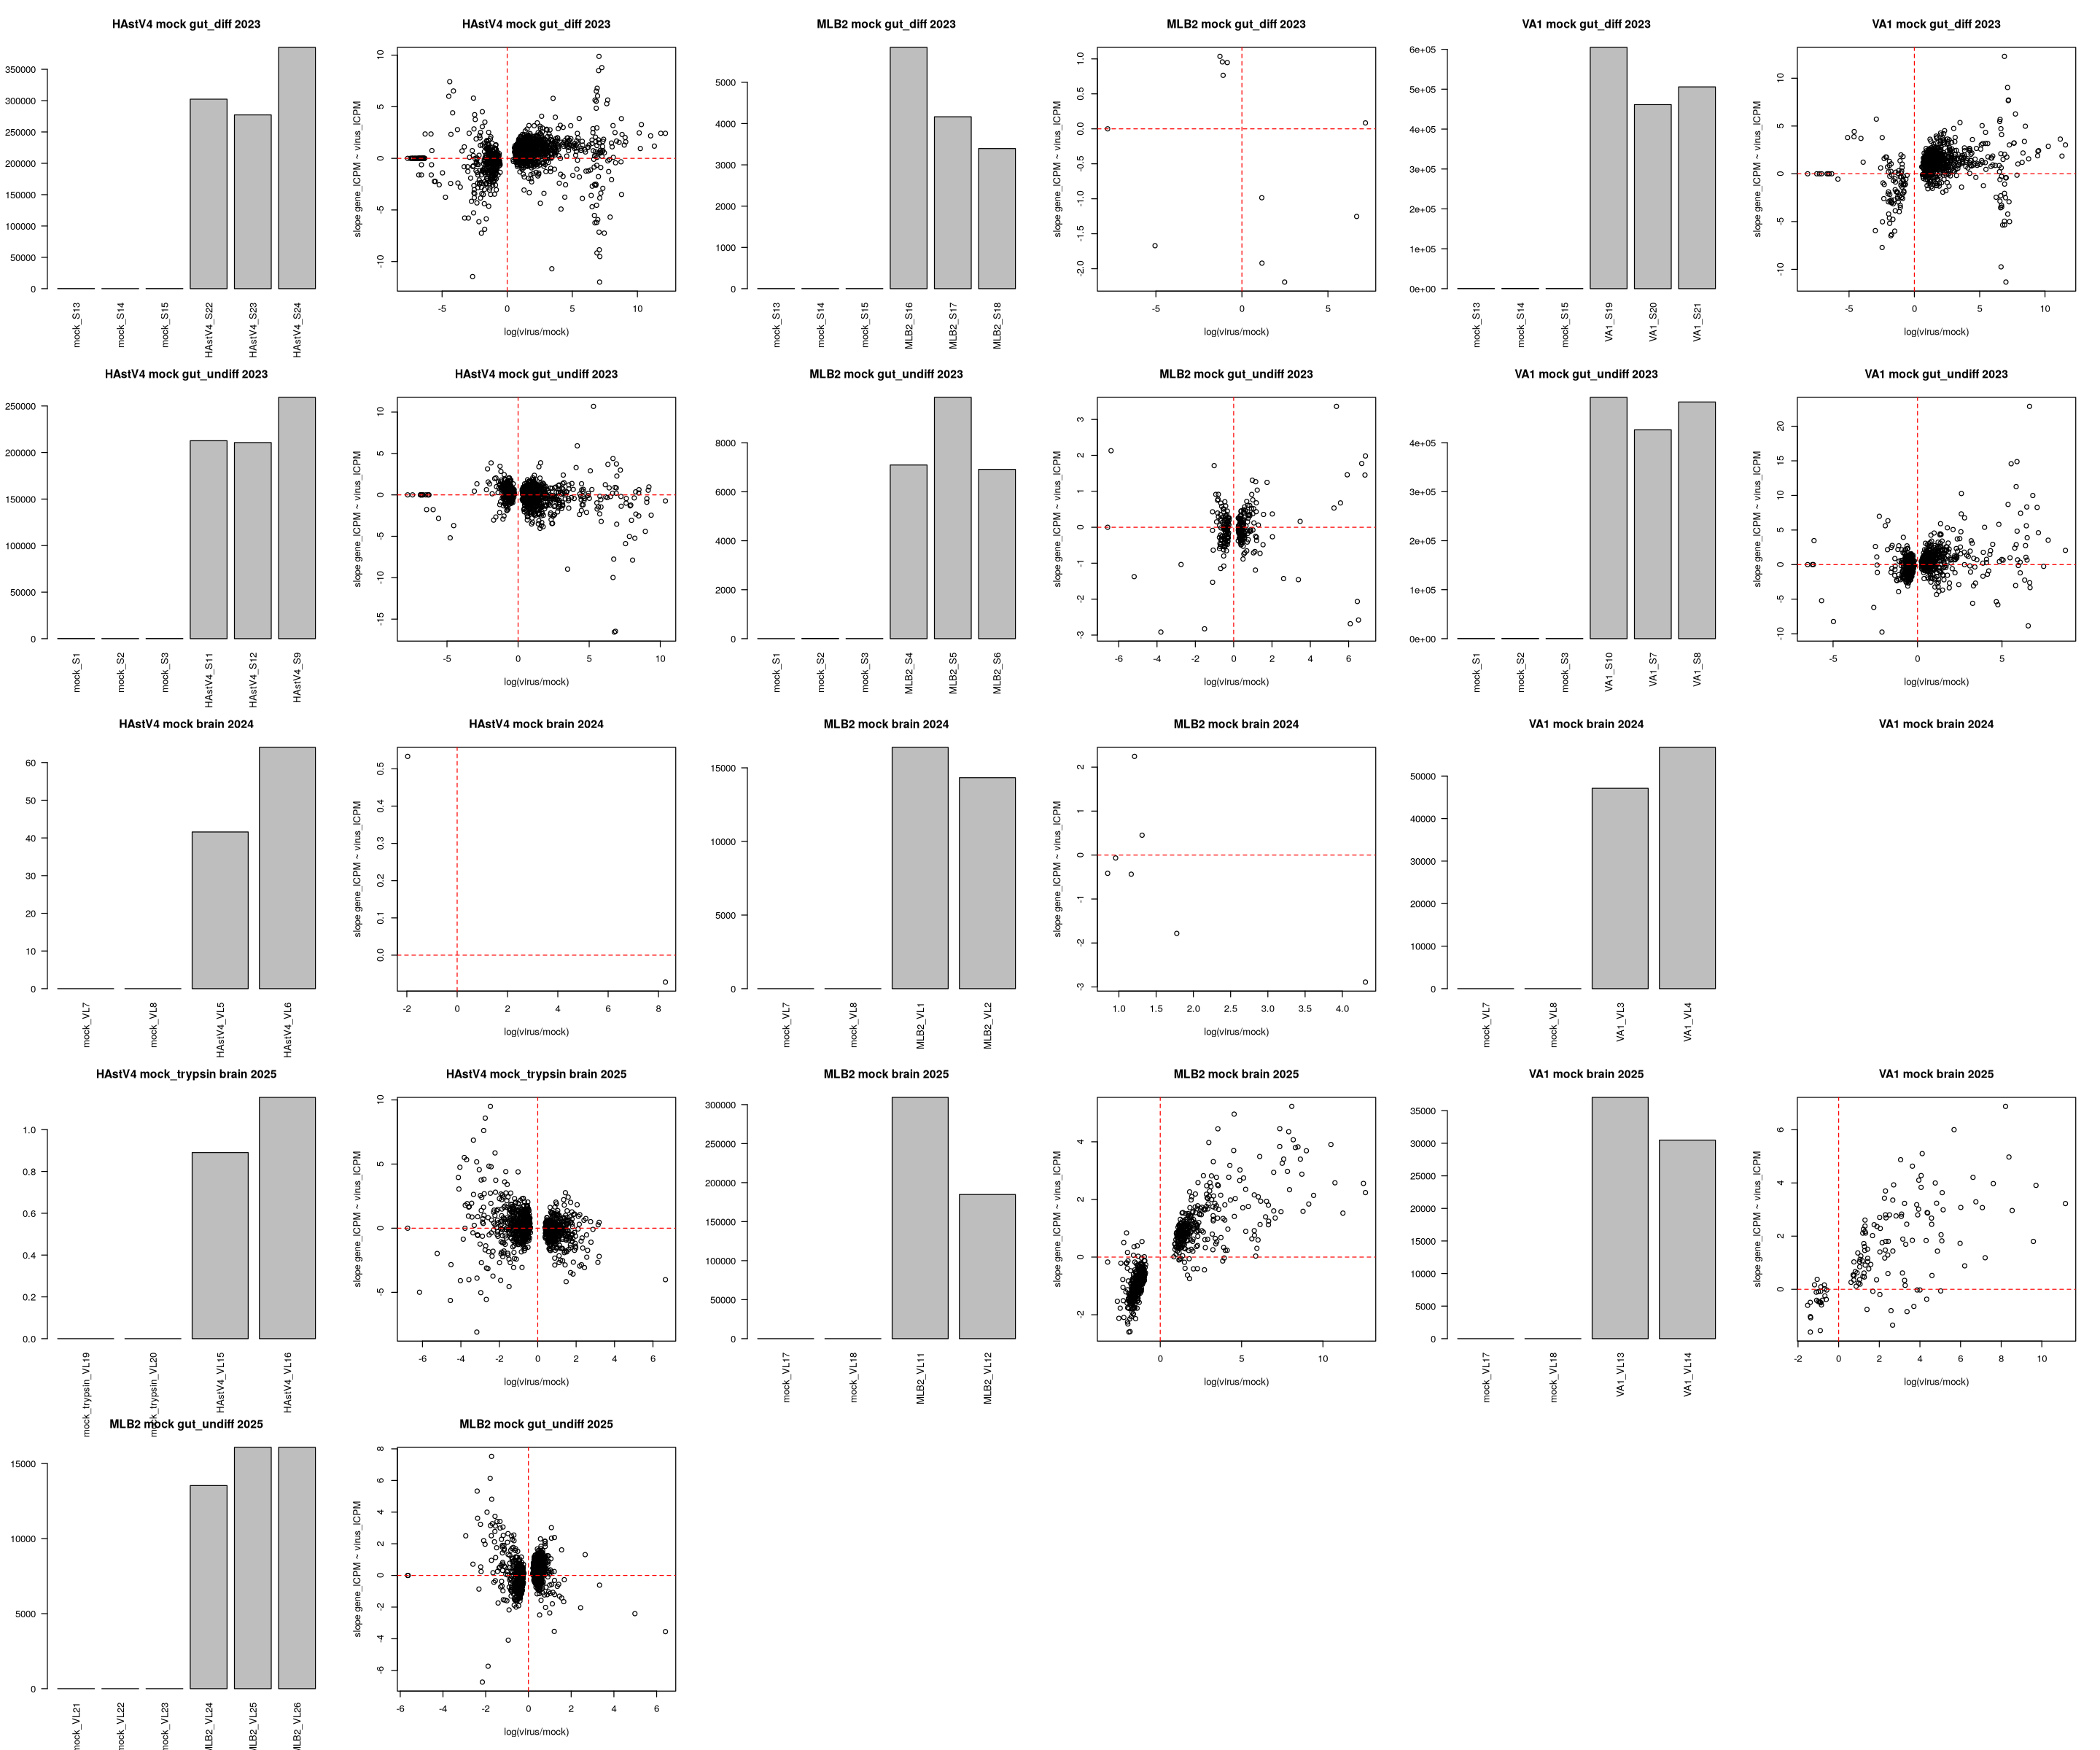

In [21]:
options(repr.plot.width=6*4, repr.plot.height=5*4)
par(mfrow=c(5,6))
groups$viral_l2fc = groups$nsgn = groups$corr = NA
for(g in seq_len(nrow(groups))){
    x=dosage_effect[[g]]$test
    s=dosage_effect[[g]]$samples
    title=paste(groups$condition[g],groups$mock[g],groups$exp_system[g] ,groups$dataset[g])
    barplot(expm1(s$viral_dosage),names.arg = paste0(s$condition,'_',s$id),las=2,main=title)
    
    f = x$padj <= 0.05
    f[is.na(f)] = FALSE
    if(sum(f)==0){
        plot.new()
        title(main=title)
        next()
    }
    groups$corr[g] = cor(x$log2FoldChange[f],x$dosage_slope[f],method = 'sp')
    groups$nsgn[g] = sum(f)
    groups$viral_lfc[g] = max(s$viral_dosage[s$condition == groups$condition[g]]) - min(s$viral_dosage[s$condition == groups$condition[g]])
    plot(x$log2FoldChange[f],x$dosage_slope[f],xlab='log(virus/mock)',ylab='slope gene_lCPM ~ virus_lCPM',main=title)
    abline(h=0,lty=2,col='red')
    abline(v=0,lty=2,col='red')
}

In [22]:
groups[order(groups$corr,decreasing = T),]

,condition,exp_system,dataset,mock,corr,nsgn,viral_l2fc,viral_lfc
,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<lgl>,<dbl>
VL11,MLB2,brain,2025,mock,0.8831046,636,NA,0.5150125
VL13,VA1,brain,2025,mock,0.6670063,141,NA,0.1949695
S22,HAstV4,gut_diff,2023,mock,0.3600635,1438,NA,0.3283227
S10,VA1,gut_undiff,2023,mock,0.3494574,834,NA,0.1445097
S19,VA1,gut_diff,2023,mock,0.3202560,716,NA,0.2708066
VL24,MLB2,gut_undiff,2025,mock,0.2499900,1283,NA,0.1724005
S4,MLB2,gut_undiff,2023,mock,0.1200908,279,NA,0.3541504
VL15,HAstV4,brain,2025,mock_trypsin,-0.2262198,948,NA,0.1307769
S11,HAstV4,gut_undiff,2023,mock,-0.2443063,909,NA,0.2075131


In [23]:
dosage_effect[[10]]$samples

,id,condition,replicate,tissue,organoid stage,organoid line,timepoint,name,dataset,HAstV4_cpm,MLB2_cpm,VA1_cpm,exp_system,viral_dosage
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
VL19,VL19,mock_trypsin,s1,brain,NA,NA,10d,mock+trypsin_brain_s1_10d_VL19,2025,0.0000000,0.07683504,0,brain,0.0000000
VL20,VL20,mock_trypsin,s2,brain,NA,NA,10d,mock+trypsin_brain_s2_10d_VL20,2025,0.0000000,0.00000000,0,brain,0.0000000
VL15,VL15,HAstV4,s1,brain,NA,NA,10d,HAstV4_brain_s1_10d_VL15,2025,0.8903165,0.00000000,0,brain,0.6367443
VL16,VL16,HAstV4,s2,brain,NA,NA,10d,HAstV4_brain_s2_10d_VL16,2025,1.1544192,0.07696128,0,brain,0.7675212


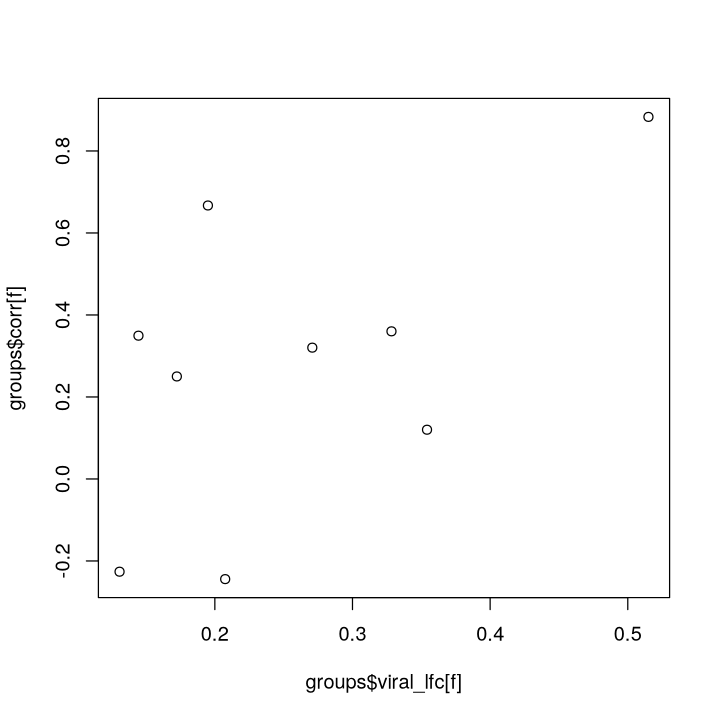

In [24]:
options(repr.plot.width=6, repr.plot.height=6)
f = groups$nsgn> 20
plot(groups$viral_lfc[f],groups$corr[f])

# infection * tissue 

In [25]:
f = all_samples$dataset=='2025' & (all_samples$condition %in% c('mock','MLB2'))
all_samples[f,]

,id,condition,replicate,tissue,organoid stage,organoid line,timepoint,name,dataset,HAstV4_cpm,MLB2_cpm,VA1_cpm,exp_system
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
VL11,VL11,MLB2,s1,brain,NA,NA,10d,MLB2_brain_s1_10d_VL11,2025,0,309283.63,0,brain
VL12,VL12,MLB2,s2,brain,NA,NA,10d,MLB2_brain_s2_10d_VL12,2025,0,184794.44,0,brain
VL17,VL17,mock,s1,brain,NA,NA,10d,mock_brain_s1_10d_VL17,2025,0,0.00,0,brain
VL18,VL18,mock,s2,brain,NA,NA,10d,mock_brain_s2_10d_VL18,2025,0,0.00,0,brain
VL21,VL21,mock,s1,gut,undiff,duo354,24h,mock_gut_undiff_duo354_s1_VL21,2025,0,0.00,0,gut_undiff
VL22,VL22,mock,s2,gut,undiff,duo354,24h,mock_gut_undiff_duo354_s2_VL22,2025,0,0.00,0,gut_undiff
VL23,VL23,mock,s3,gut,undiff,duo354,24h,mock_gut_undiff_duo354_s3_VL23,2025,0,0.00,0,gut_undiff
VL24,VL24,MLB2,s1,gut,undiff,duo354,24h,MLB2_gut_undiff_duo354_s1_VL24,2025,0,13533.45,0,gut_undiff
VL25,VL25,MLB2,s2,gut,undiff,duo354,24h,MLB2_gut_undiff_duo354_s2_VL25,2025,0,16079.74,0,gut_undiff


In [26]:
deseq = DESeqDataSetFromMatrix(countData = pcounts[,f],
                                  colData = all_samples[f,],
                                   design = ~ condition + tissue + condition:tissue)
deseq = DESeq(deseq,quiet = TRUE)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [182]:
test = results(deseq,name='conditionmock.tissuegut', independentFiltering=FALSE)
#test = results(deseq,contrast = c('condition','MLB2','mock'), independentFiltering=FALSE)

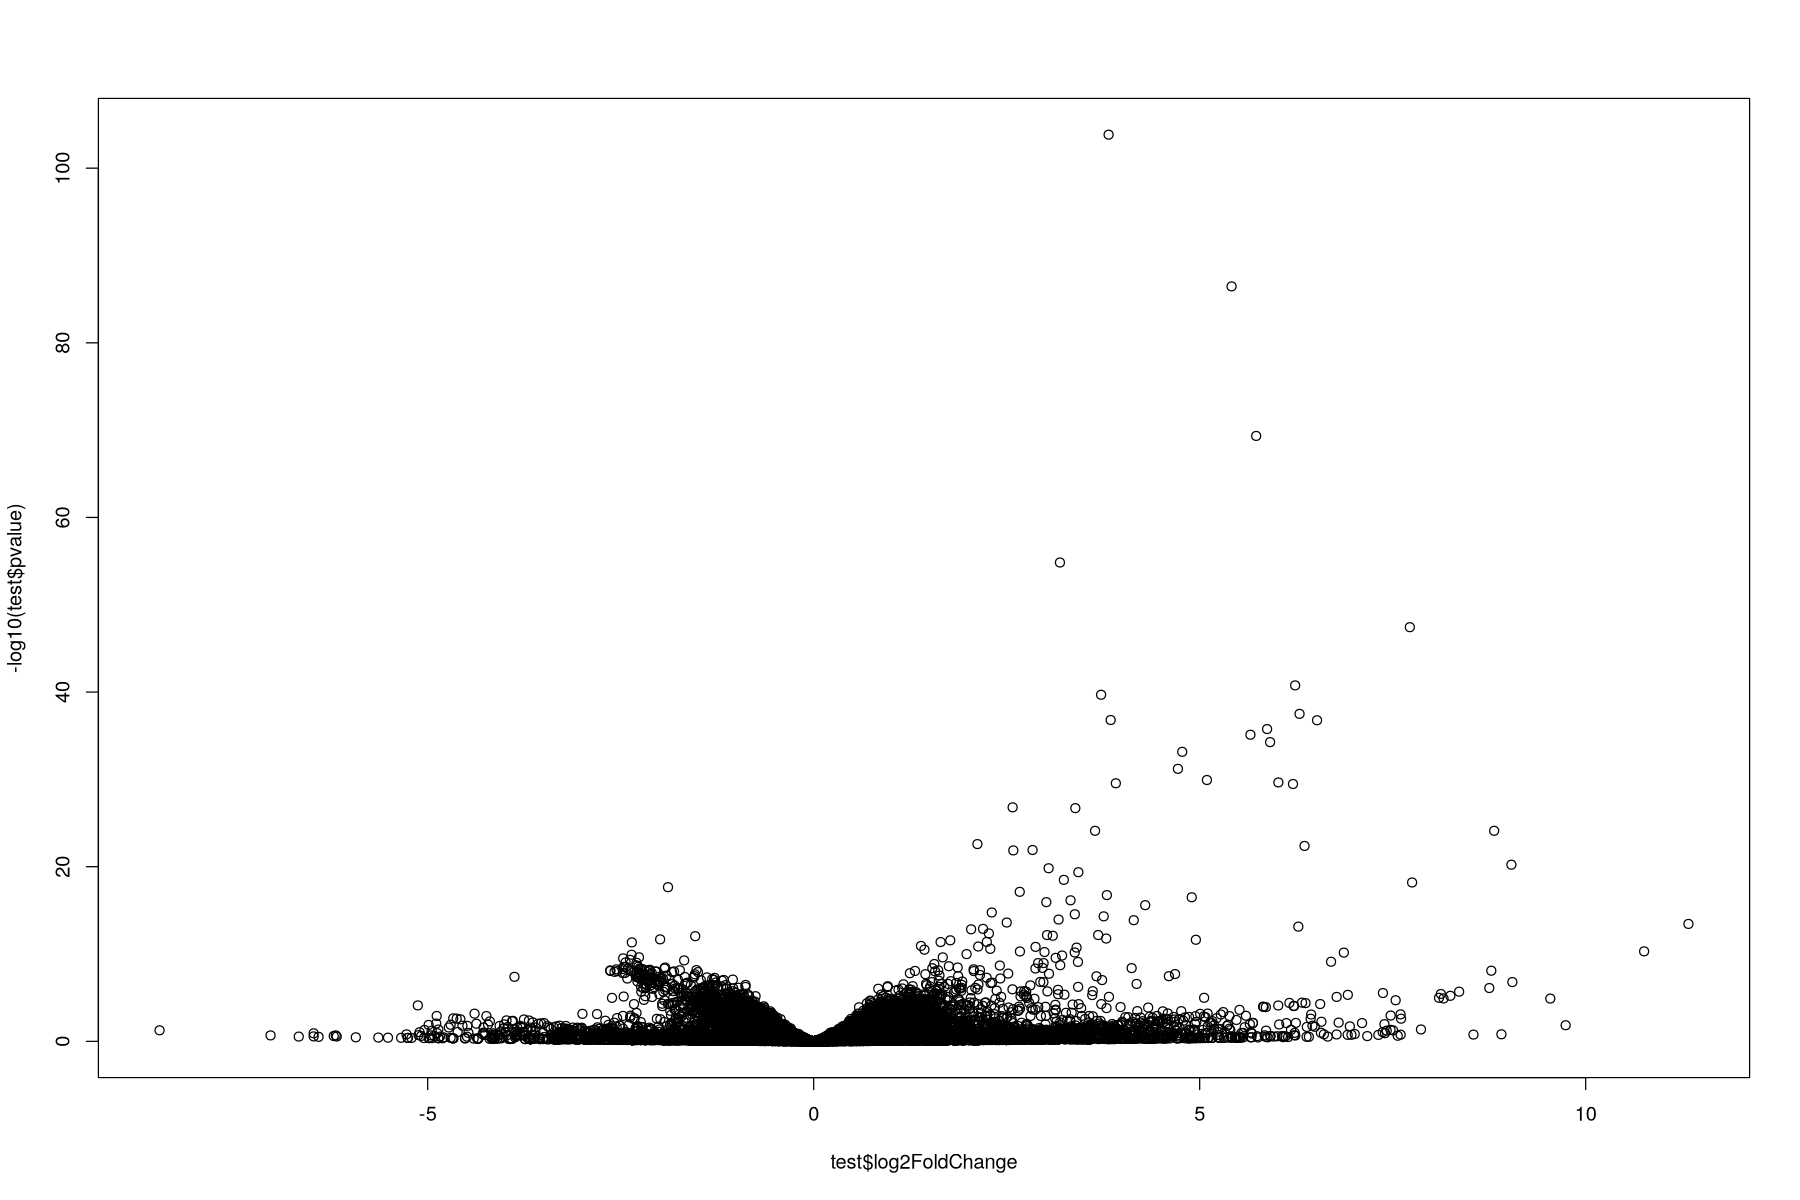

In [183]:
plot(test$log2FoldChange,-log10(test$pvalue))

In [184]:
top10=test[order(abs(test$log2FoldChange),decreasing = T),]
top10 = top10[!is.na(top10$padj ) & top10$padj < 0.05,]
top10 = top10[1:10,]
top10

log2 fold change (MLE): conditionmock.tissuegut 
Wald test p-value: conditionmock.tissuegut 
DataFrame with 10 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat      pvalue
                 <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000205413 1132.48528       11.33131  1.495735   7.57575 3.57068e-14
ENSG00000221963 3378.51782       10.75706  1.636622   6.57272 4.94042e-11
ENSG00000130487    8.09239        9.54207  2.185377   4.36633 1.26354e-05
ENSG00000049249   84.92073        9.05043  1.727823   5.23805 1.62279e-07
ENSG00000089127 1690.29821        9.03790  0.962255   9.39242 5.86385e-21
ENSG00000111331  805.73578        8.81460  0.856476  10.29171 7.68041e-25
ENSG00000177409 1063.66454        8.77745  1.522592   5.76481 8.17517e-09
ENSG00000133321  325.73848        8.75182  1.772101   4.93867 7.86575e-07
ENSG00000169248   63.74412        8.36090  1.760740   4.74851 2.04917e-06
ENSG00000153064  332.25291        8.24701  1.823689   4.

In [185]:
genes[rownames(top10),]

,chr,start,end,strand,gene_id,gene_name,gene_biotype
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
ENSG00000205413,7,93099513,93118023,-,ENSG00000205413,SAMD9,protein_coding
ENSG00000221963,22,35648446,35668404,+,ENSG00000221963,APOL6,protein_coding
ENSG00000130487,22,50545899,50551023,+,ENSG00000130487,KLHDC7B,protein_coding
ENSG00000049249,1,7915871,7943165,-,ENSG00000049249,TNFRSF9,protein_coding
ENSG00000089127,12,112905856,112933219,+,ENSG00000089127,OAS1,protein_coding
ENSG00000111331,12,112938051,112976460,+,ENSG00000111331,OAS3,protein_coding
ENSG00000177409,7,93130056,93148385,-,ENSG00000177409,SAMD9L,protein_coding
ENSG00000133321,11,63536808,63546462,+,ENSG00000133321,PLAAT4,protein_coding
ENSG00000169248,4,76033682,76041415,-,ENSG00000169248,CXCL11,protein_coding


In [186]:
cpm = counts(deseq,norm=T)

In [187]:
samples = all_samples[colnames(deseq),]
samples$label = paste0(samples$tissue,'_',samples$condition,'_',samples$id)
samples$col = ifelse(samples$tissue=='brain','#FF0000','#00FF00')
samples$col = paste0(samples$col,ifelse(samples$condition=='mock','30','FF'))

o = order(samples$tissue,samples$condition=='MLB2')

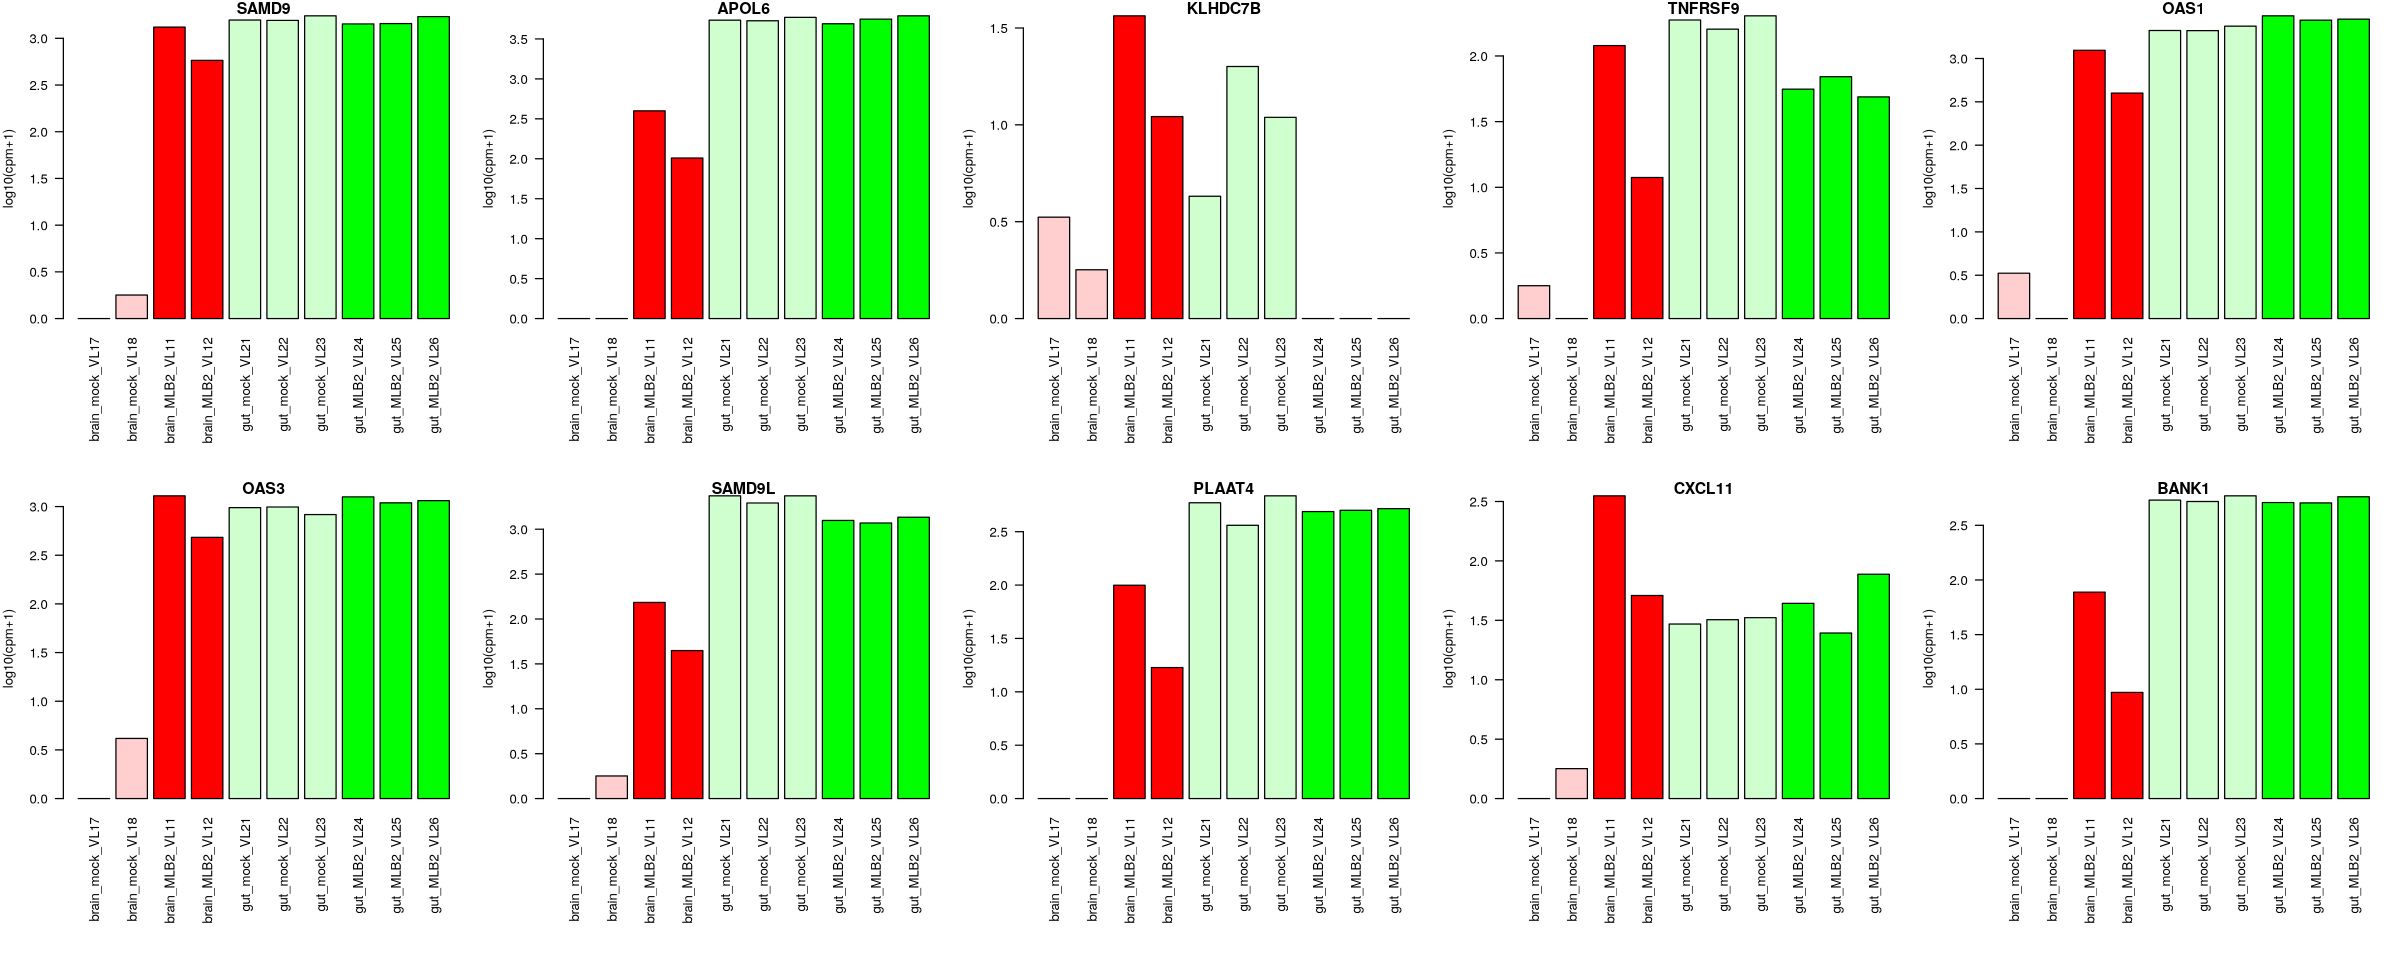

In [188]:
par(mar=c(10,4,1,1),mfrow=c(2,5))
options(repr.plot.width=5*4, repr.plot.height=2*4)
for(gid in rownames(top10)){
    barplot(log10(1+cpm[gid,o]),names.arg = samples$label[o],las=2,ylab='log10(cpm+1)',main=paste0(genes[gid,'gene_name']),col=samples$col[o])
}

In [189]:
f = test$padj < 0.05 & abs(test$log2FoldChange)>1
f[is.na(f)] = FALSE
table(f)

f
FALSE  TRUE 
18774  1296 

In [190]:
lcpm_sgn = t(scale(t(log10(cpm[f,o]+1))))
#lcpm_sgn = log10(cpm[f,o]+1)

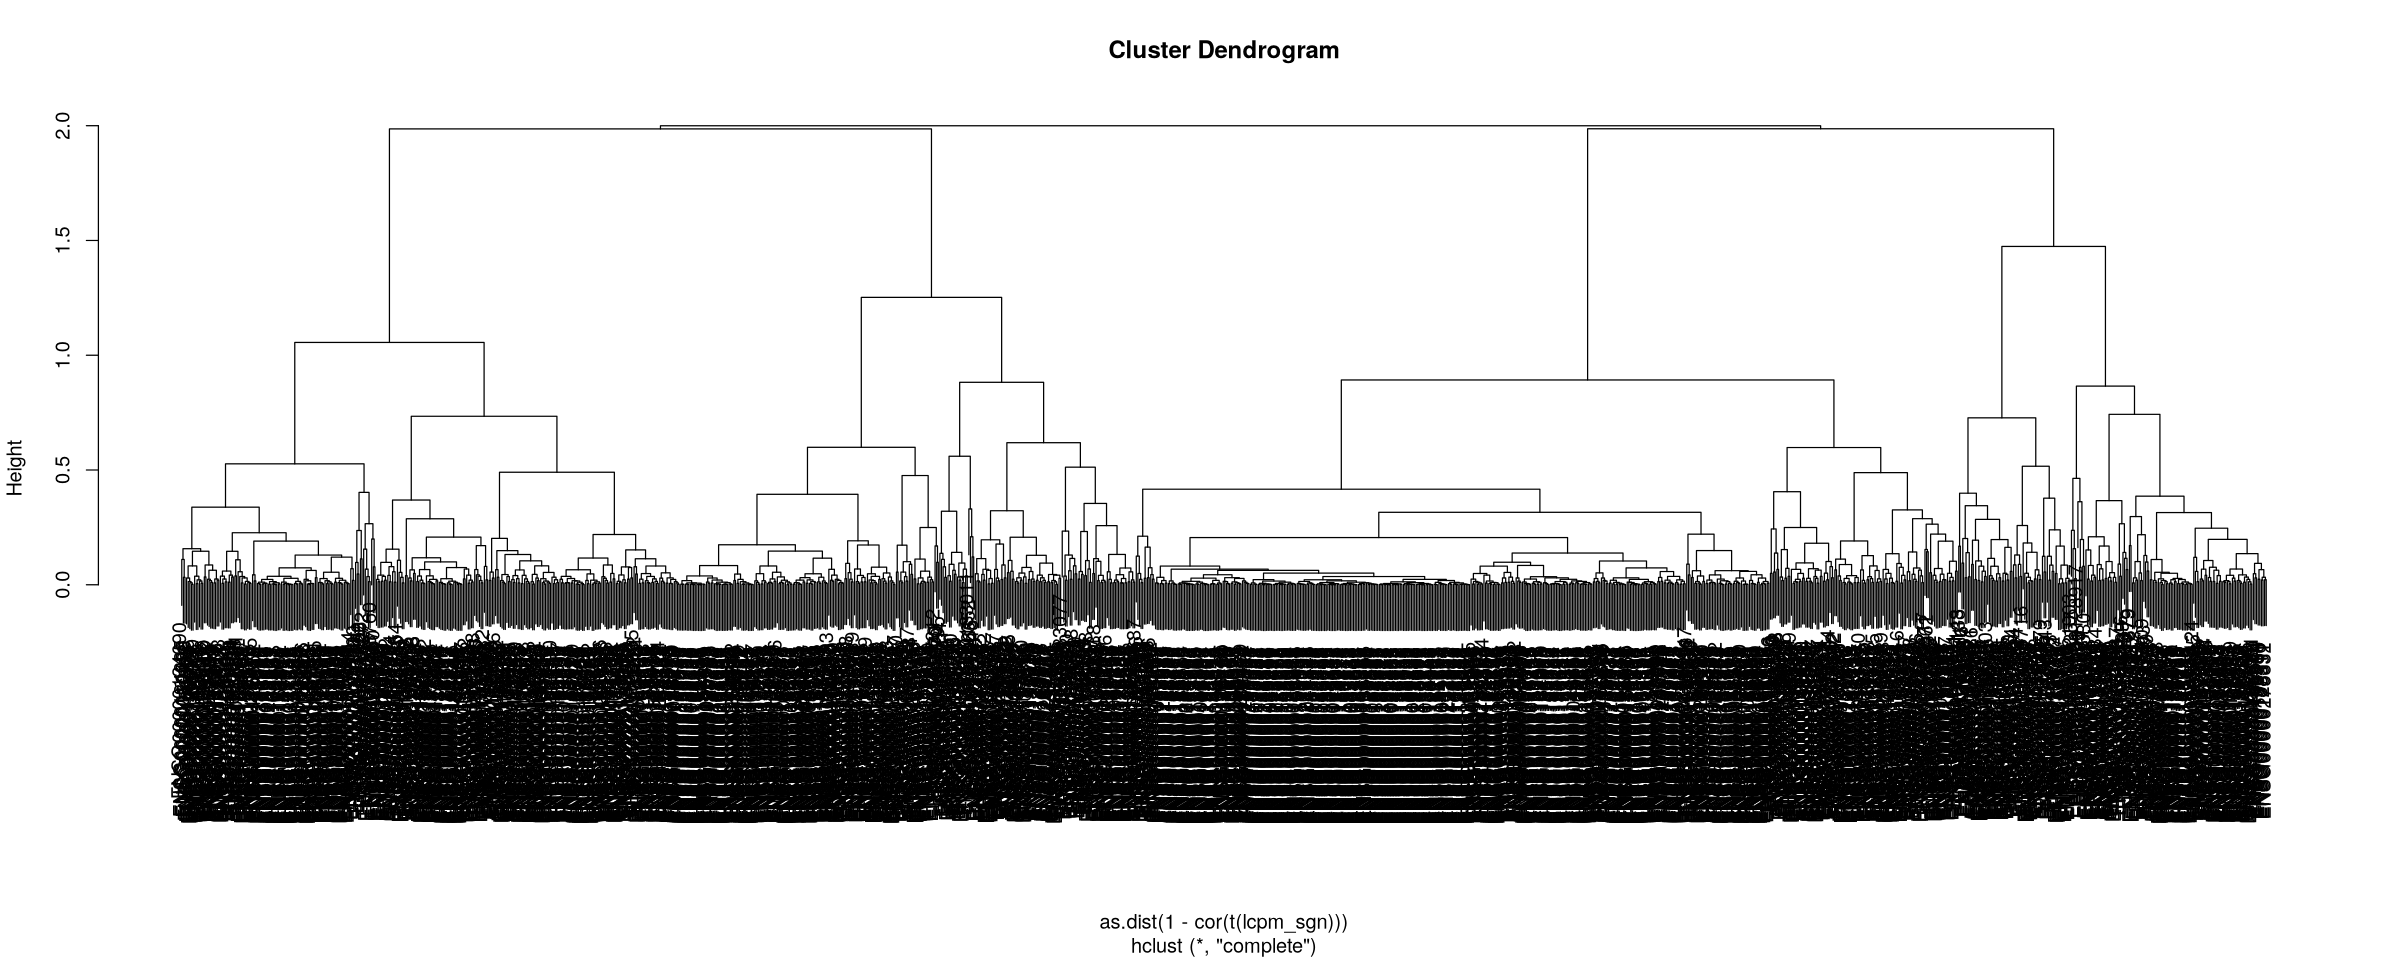

In [191]:
hcl = hclust(as.dist(1-cor(t(lcpm_sgn))))
plot(hcl)

In [192]:
cl = cutree(hcl,k = 6)
table(cl)

cl
  1   2   3   4   5   6 
511  70 161 310 122 122 

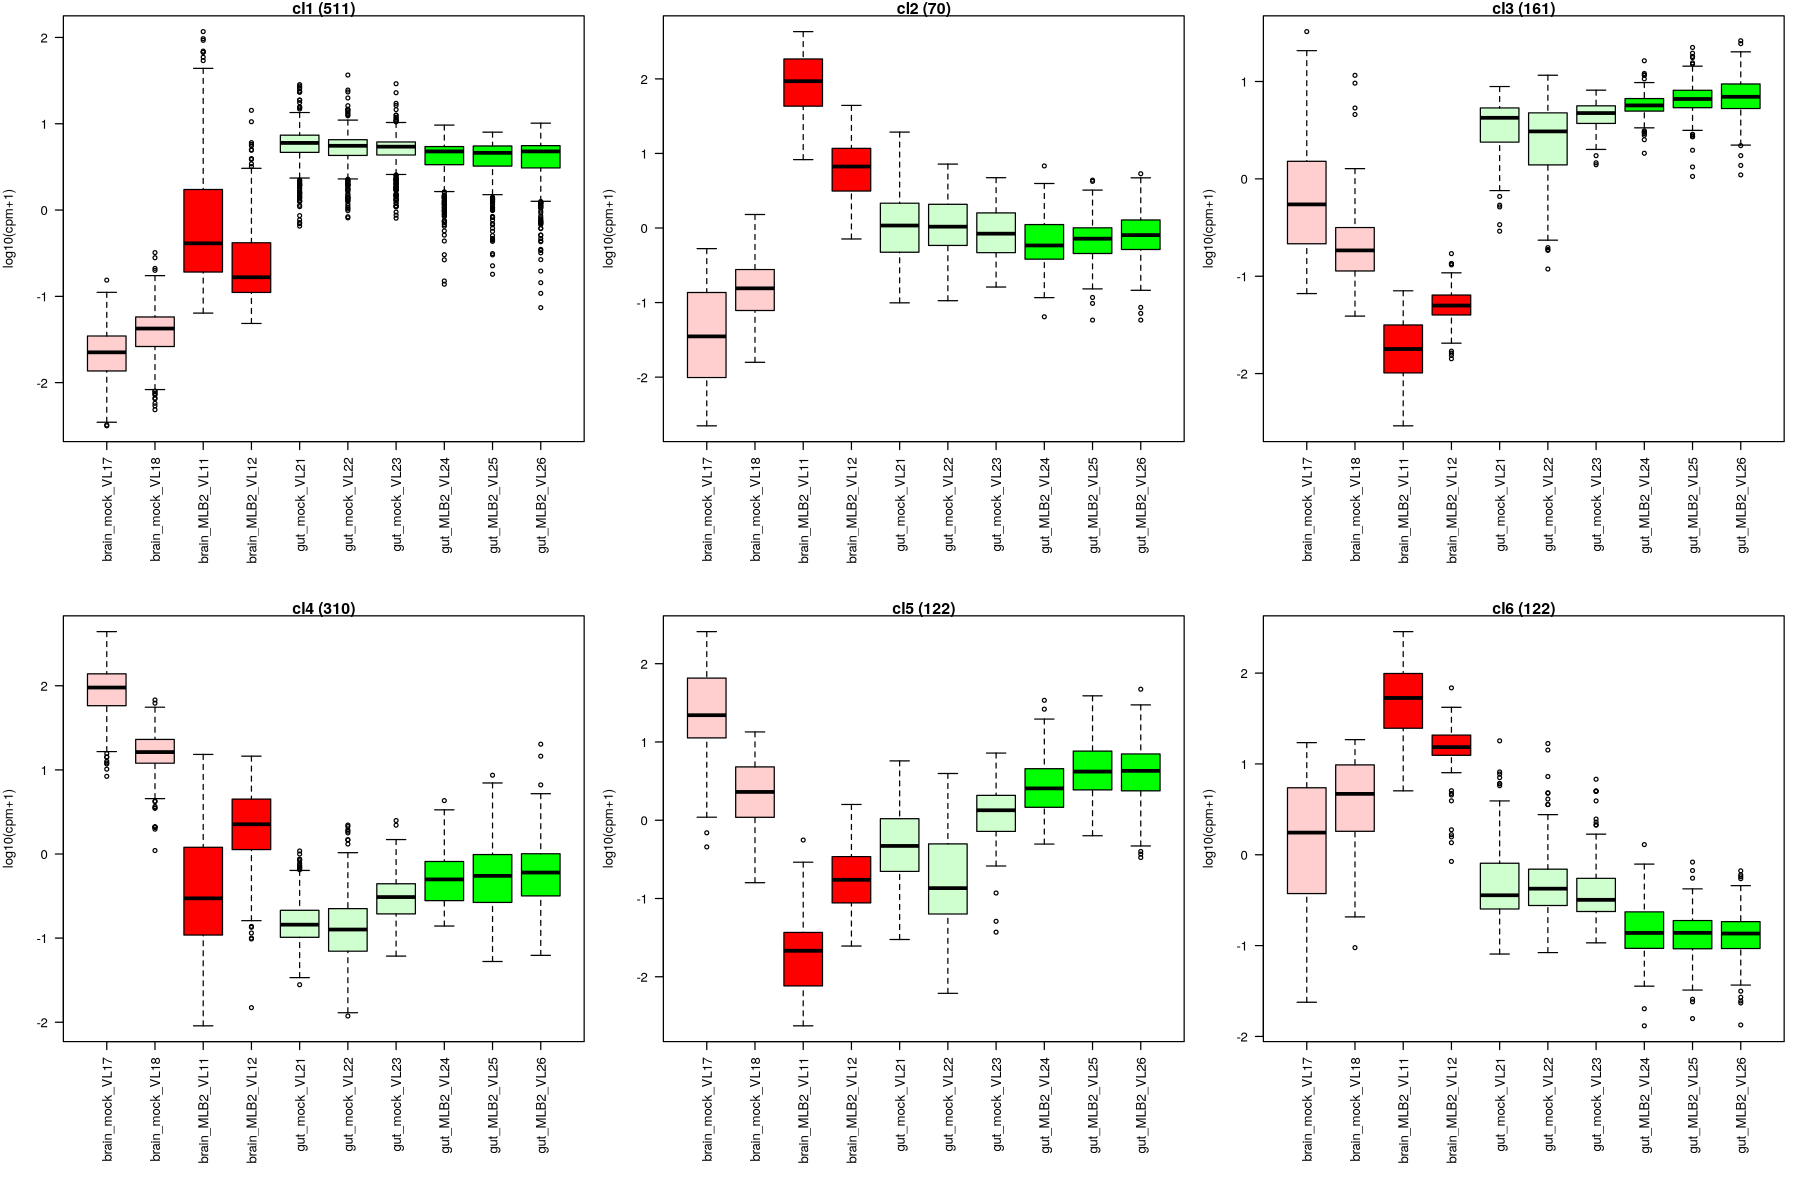

In [193]:
par(mar=c(10,4,1,1),mfrow=c(2,3))
options(repr.plot.width=15, repr.plot.height=10)
for(c in sort(unique(cl))){
    boxplot(lcpm_sgn[cl==c,],col=samples$col[o],names = samples$label[o],las=2,ylab='log10(cpm+1)',main=paste0('cl',c,' (',sum(cl==c),')'))
}

In [194]:
samples

,id,condition,replicate,tissue,organoid stage,organoid line,timepoint,name,dataset,HAstV4_cpm,MLB2_cpm,VA1_cpm,exp_system,label,col
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
VL11,VL11,MLB2,s1,brain,NA,NA,10d,MLB2_brain_s1_10d_VL11,2025,0,309283.63,0,brain,brain_MLB2_VL11,#FF0000FF
VL12,VL12,MLB2,s2,brain,NA,NA,10d,MLB2_brain_s2_10d_VL12,2025,0,184794.44,0,brain,brain_MLB2_VL12,#FF0000FF
VL17,VL17,mock,s1,brain,NA,NA,10d,mock_brain_s1_10d_VL17,2025,0,0.00,0,brain,brain_mock_VL17,#FF000030
VL18,VL18,mock,s2,brain,NA,NA,10d,mock_brain_s2_10d_VL18,2025,0,0.00,0,brain,brain_mock_VL18,#FF000030
VL21,VL21,mock,s1,gut,undiff,duo354,24h,mock_gut_undiff_duo354_s1_VL21,2025,0,0.00,0,gut_undiff,gut_mock_VL21,#00FF0030
VL22,VL22,mock,s2,gut,undiff,duo354,24h,mock_gut_undiff_duo354_s2_VL22,2025,0,0.00,0,gut_undiff,gut_mock_VL22,#00FF0030
VL23,VL23,mock,s3,gut,undiff,duo354,24h,mock_gut_undiff_duo354_s3_VL23,2025,0,0.00,0,gut_undiff,gut_mock_VL23,#00FF0030
VL24,VL24,MLB2,s1,gut,undiff,duo354,24h,MLB2_gut_undiff_duo354_s1_VL24,2025,0,13533.45,0,gut_undiff,gut_MLB2_VL24,#00FF00FF
VL25,VL25,MLB2,s2,gut,undiff,duo354,24h,MLB2_gut_undiff_duo354_s2_VL25,2025,0,16079.74,0,gut_undiff,gut_MLB2_VL25,#00FF00FF


In [195]:
split(names(cl),cl) # for clusterProfiler

$`1`
  [1] "ENSG00000184677" "ENSG00000143036" "ENSG00000198198" "ENSG00000162688"
  [5] "ENSG00000162664" "ENSG00000184371" "ENSG00000135842" "ENSG00000143842"
  [9] "ENSG00000116711" "ENSG00000196878" "ENSG00000074964" "ENSG00000169231"
 [13] "ENSG00000156869" "ENSG00000173846" "ENSG00000116977" "ENSG00000196517"
 [17] "ENSG00000198890" "ENSG00000143369" "ENSG00000162390" "ENSG00000163131"
 [21] "ENSG00000117226" "ENSG00000117228" "ENSG00000162654" "ENSG00000085831"
 [25] "ENSG00000196187" "ENSG00000171824" "ENSG00000179023" "ENSG00000152763"
 [29] "ENSG00000142661" "ENSG00000185436" "ENSG00000014914" "ENSG00000132849"
 [33] "ENSG00000221978" "ENSG00000155363" "ENSG00000211454" "ENSG00000162482"
 [37] "ENSG00000007923" "ENSG00000116455" "ENSG00000134716" "ENSG00000142961"
 [41] "ENSG00000163565" "ENSG00000016602" "ENSG00000174827" "ENSG00000049249"
 [45] "ENSG00000281406" "ENSG00000158286" "ENSG00000117480" "ENSG00000162772"
 [49] "ENSG00000178295" "ENSG00000158125" "ENSG00000115616" "ENSG00000172086"
 [53] "ENSG00000163121" "ENSG00000196872" "ENSG00000064989" "ENSG00000067066"
 [57] "ENSG00000196141" "ENSG00000135637" "ENSG00000115282" "ENSG00000144045"
 [61] "ENSG00000163482" "ENSG00000185404" "ENSG00000134321" "ENSG00000123609"
 [65] "ENSG00000115993" "ENSG00000152527" "ENSG00000003402" "ENSG00000124839"
 [69] "ENSG00000082438" "ENSG00000155066" "ENSG00000115267" "ENSG00000135899"
 [73] "ENSG00000178623" "ENSG00000144043" "ENSG00000085982" "ENSG00000213699"
 [77] "ENSG00000115841" "ENSG00000126062" "ENSG00000206530" "ENSG00000173193"
 [81] "ENSG00000121858" "ENSG00000136514" "ENSG00000113790" "ENSG00000113916"
 [85] "ENSG00000163898" "ENSG00000163714" "ENSG00000163347" "ENSG00000168016"
 [89] "ENSG00000114529" "ENSG00000188313" "ENSG00000114127" "ENSG00000174640"
 [93] "ENSG00000177646" "ENSG00000164050" "ENSG00000114841" "ENSG00000168386"
 [97] "ENSG00000144821" "ENSG00000182983" "ENSG00000182179" "ENSG00000138496"
[101] "ENSG00000163840" "ENSG00000145022" "ENSG00000176945" "ENSG00000144802"
[105] "ENSG00000078070" "ENSG00000078081" "ENSG00000157765" "ENSG00000153064"
[109] "ENSG00000124875" "ENSG00000151470" "ENSG00000071205" "ENSG00000164136"
[113] "ENSG00000038002" "ENSG00000109193" "ENSG00000186212" "ENSG00000168769"
[117] "ENSG00000164125" "ENSG00000137628" "ENSG00000128039" "ENSG00000118762"
[121] "ENSG00000118777" "ENSG00000138772" "ENSG00000169248" "ENSG00000181381"
[125] "ENSG00000168228" "ENSG00000138642" "ENSG00000169429" "ENSG00000174130"
[129] "ENSG00000178950" "ENSG00000109320" "ENSG00000164342" "ENSG00000109452"
[133] "ENSG00000163694" "ENSG00000170571" "ENSG00000145819" "ENSG00000118322"
[137] "ENSG00000183111" "ENSG00000187678" "ENSG00000113407" "ENSG00000164403"
[141] "ENSG00000120738" "ENSG00000055147" "ENSG00000125347" "ENSG00000113739"
[145] "ENSG00000039139" "ENSG00000069020" "ENSG00000197375" "ENSG00000206077"
[149] "ENSG00000164308" "ENSG00000165671" "ENSG00000145623" "ENSG00000146038"
[153] "ENSG00000065615" "ENSG00000065833" "ENSG00000170915" "ENSG00000112773"
[157] "ENSG00000130023" "ENSG00000021355" "ENSG00000204642" "ENSG00000227507"
[161] "ENSG00000204439" "ENSG00000197081" "ENSG00000204592" "ENSG00000137275"
[165] "ENSG00000010030" "ENSG00000240065" "ENSG00000130363" "ENSG00000186470"
[169] "ENSG00000124508" "ENSG00000111801" "ENSG00000197594" "ENSG00000158406"
[173] "ENSG00000204525" "ENSG00000197261" "ENSG00000234745" "ENSG00000204264"
[177] "ENSG00000168394" "ENSG00000232810" "ENSG00000231925" "ENSG00000237988"
[181] "ENSG00000079691" "ENSG00000164626" "ENSG00000204267" "ENSG00000206503"
[185] "ENSG00000146477" "ENSG00000096696" "ENSG00000146232" "ENSG00000124608"
[189] "ENSG00000118503" "ENSG00000242802" "ENSG00000164877" "ENSG00000126522"
[193] "ENSG00000136250" "ENSG00000059378" "ENSG00000126870" "ENSG00000215018"
[197] "ENSG00000146826" "ENSG00000197343" "ENSG00000050344" "ENSG00000085563"
[201] "ENSG00000127951" "ENSG00000165125" "ENSG00000197150" "ENSG00000105939"
[205] "ENSG000001

In [198]:
length(rownames(test)[!is.na(test$padj)]) #

[1] 18157

# Subgenomic RNA expression

In [73]:
#devtools::install_github("mamarkevi/plotCoverage")
library(plotCoverage)

In [75]:
#BiocManager::install("GenomicAlignments")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'GenomicAlignments'

also installing the dependencies ‘bitops’, ‘Rhtslib’, ‘Rsamtools’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'aplot', 'BiocManager', 'BiocParallel', 'bit', 'bit64', 'broom',
  'bslib', 'caret', 'cli', 'clock', 'cluster', 'commonmark', 'cpp11', 'curl',
  'data.table', 'DOSE', 'foreign', 'fs', 'future', 'future.apply', 'generics',
  'GenomeInfoDb', 'ggplot2', 'glmnet', 'globals', 'gower', 'hardhat', 'haven',
  'httpuv', 'httr2', 'jsonlite', 'knitr', 'later', 'lattice', 'locfit', 'maps',
  'MASS', 'Matrix', 'mgcv', 'mime', 'nlme', 'openssl', 'parallelly', 'pbdZMQ',
  'pheatmap', 'pillar', 'processx', 'prodlim', 'promises', 'ps', 'pu

In [85]:
covs=lapply(all_samples$id[all_samples$dataset=='2025'],function(id){
    print(id)
    plotCoverage::getReadCoverage(paste0('../../mapped/NGS-20250519/',id,'/Aligned.sortedByCoord.out.bam'),chr = 'MLB2',start = 1,end = 6138)})

[1] "VL11"
[1] "VL12"
[1] "VL13"
[1] "VL14"
[1] "VL15"
[1] "VL16"
[1] "VL17"
[1] "VL18"
[1] "VL19"
[1] "VL20"
[1] "VL21"
[1] "VL22"
[1] "VL23"
[1] "VL24"
[1] "VL25"
[1] "VL26"


In [86]:
names(covs) = all_samples$id[all_samples$dataset=='2025']

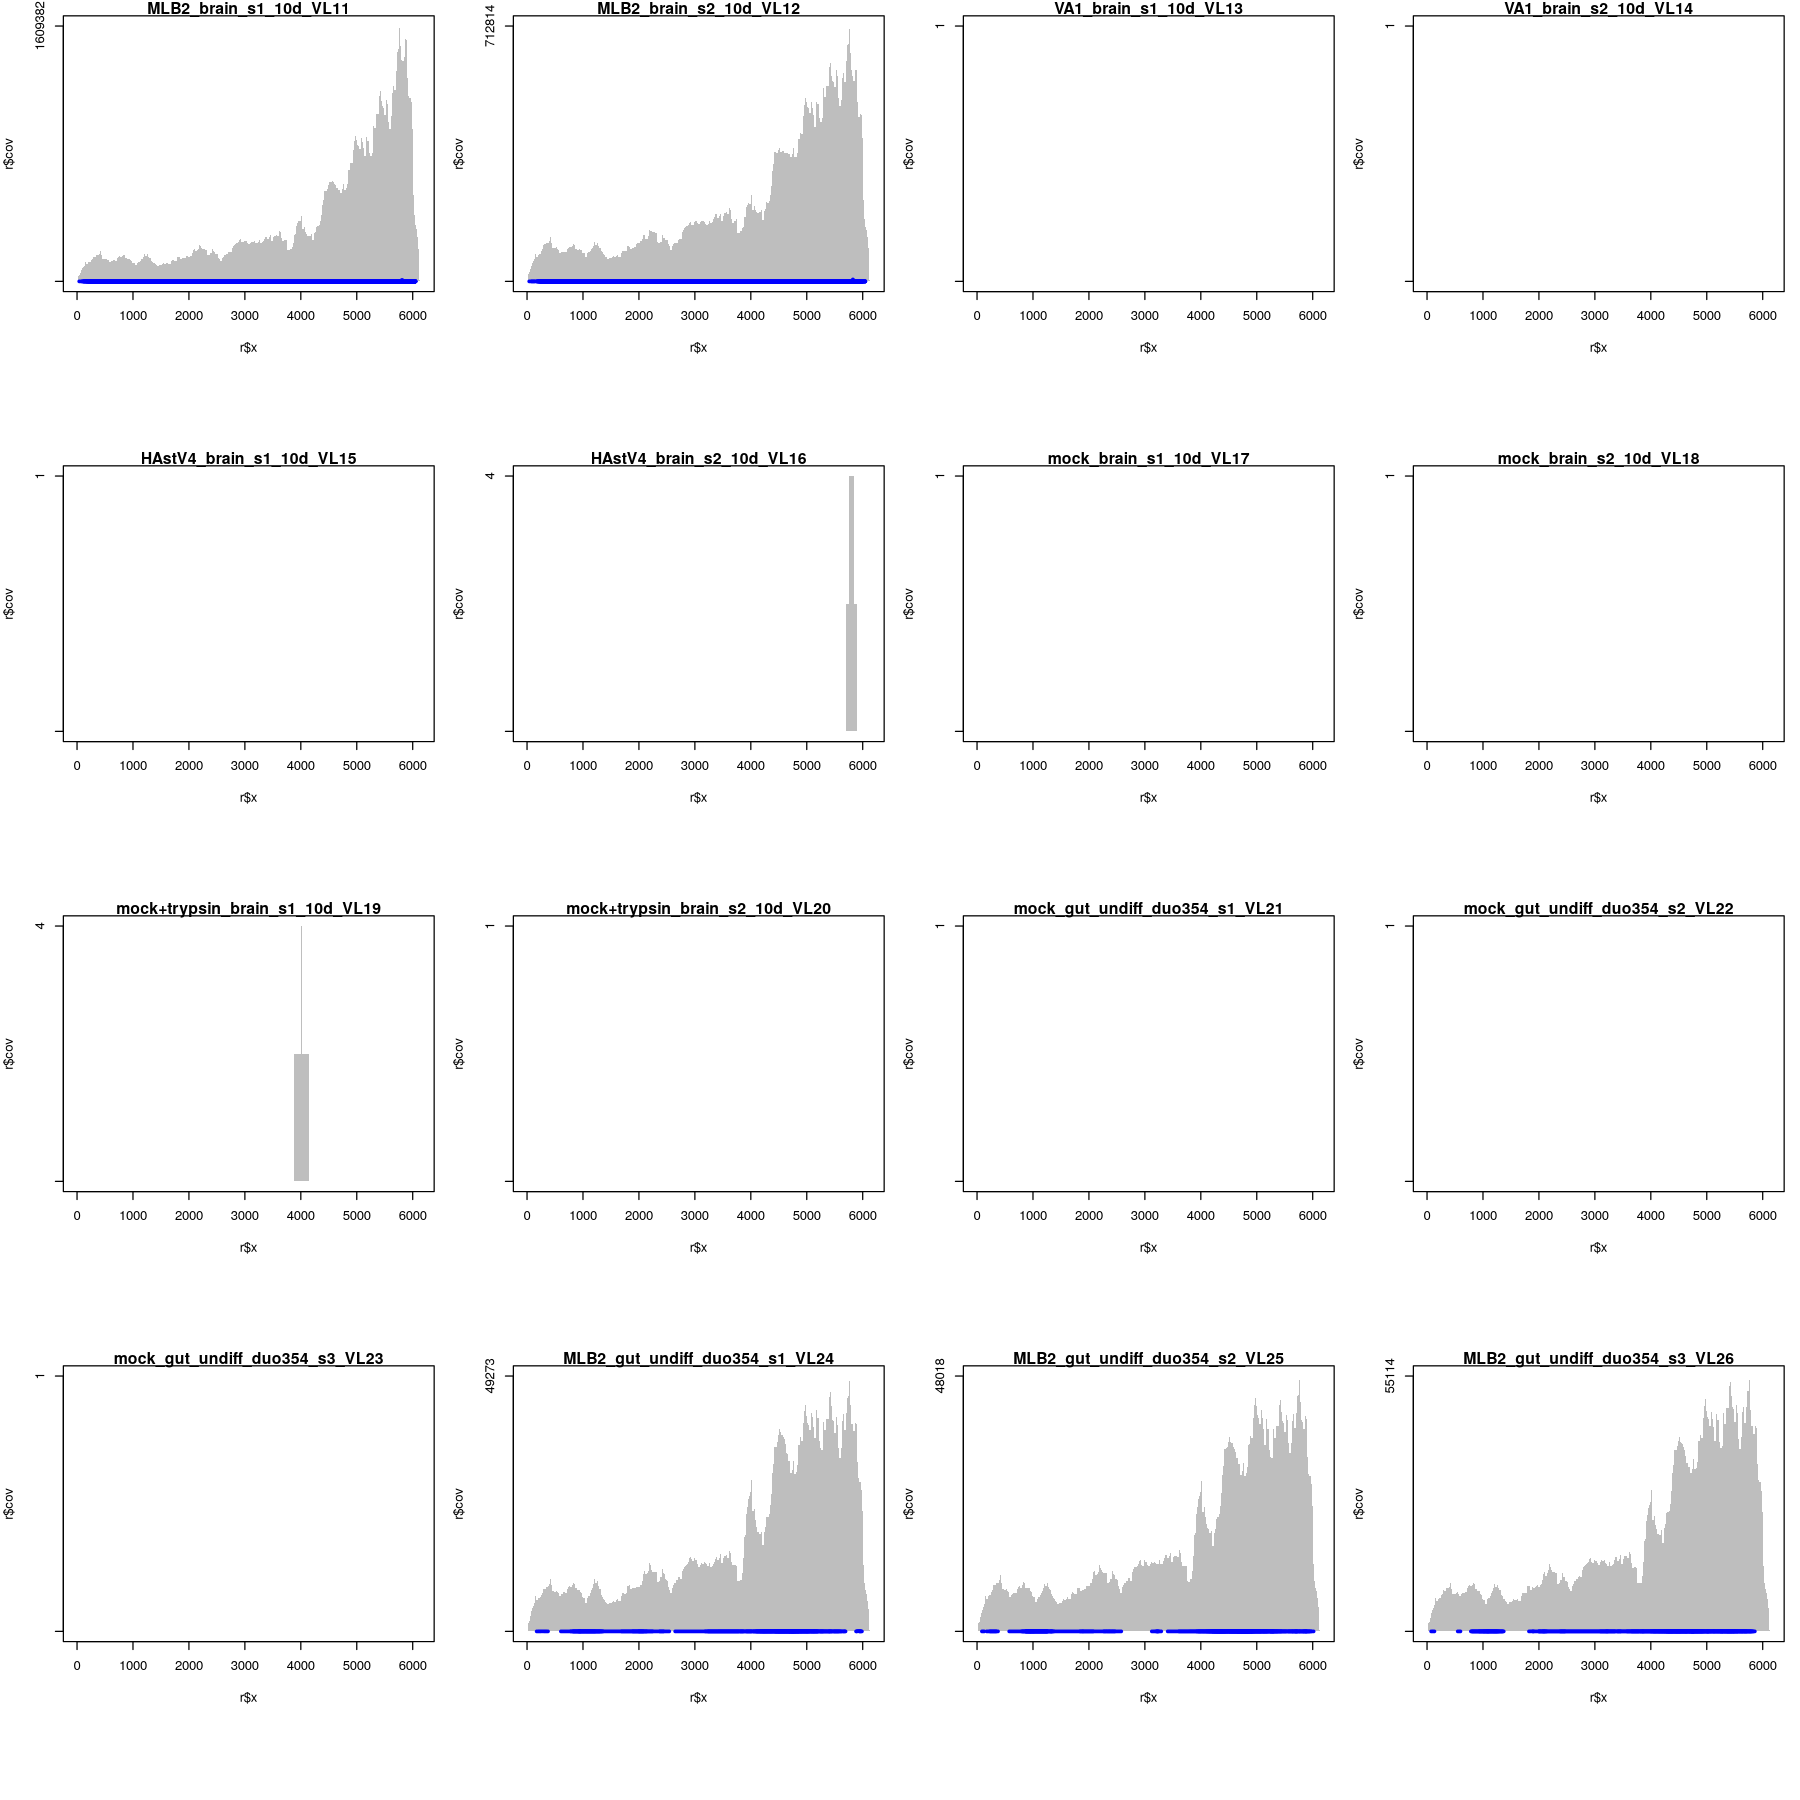

In [107]:
par(mar=c(10,4,1,1),mfrow=c(4,4))
options(repr.plot.width=15, repr.plot.height=15)
for(n in names(covs))
    plotCoverage::plotReadCov(covs[[n]],main=all_samples[n,'name'])#,ylim = c(0,max(c(1,covs[[n]]$juncs$score))),xlim=c(5750,5900))

In [103]:
covs[[1]]$juncs[order(covs[[1]]$juncs$score,decreasing = T)[1:10],]

,seqnames,start,end,width,strand,score,plus_score,minus_score
,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>
MLB2-5791-5829,MLB2,5791,5829,39,*,9148,5976,3172
MLB2-5812-5835,MLB2,5812,5835,24,*,1349,820,529
MLB2-5748-5888,MLB2,5748,5888,141,*,61,26,35
MLB2-5868-5890,MLB2,5868,5890,23,*,47,24,23
MLB2-5815-5835,MLB2,5815,5835,21,*,31,19,12
MLB2-2806-5888,MLB2,2806,5888,3083,*,29,15,14
MLB2-4470-4548,MLB2,4470,4548,79,*,29,20,9
MLB2-5131-5195,MLB2,5131,5195,65,*,29,9,20
MLB2-5746-5888,MLB2,5746,5888,143,*,26,10,16


In [105]:
covs[[2]]$juncs[order(covs[[2]]$juncs$score,decreasing = T)[1:10],]

,seqnames,start,end,width,strand,score,plus_score,minus_score
,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>
MLB2-5815-5835,MLB2,5815,5835,21,*,5420,3321,2099
MLB2-2383-5709,MLB2,2383,5709,3327,*,23,23,0
MLB2-3656-4837,MLB2,3656,4837,1182,*,12,12,0
MLB2-5636-5676,MLB2,5636,5676,41,*,12,4,8
MLB2-3377-4429,MLB2,3377,4429,1053,*,10,5,5
MLB2-3876-4973,MLB2,3876,4973,1098,*,10,3,7
MLB2-3129-3917,MLB2,3129,3917,789,*,8,8,0
MLB2-3214-4437,MLB2,3214,4437,1224,*,8,4,4
MLB2-5276-5970,MLB2,5276,5970,695,*,8,0,8
